In [1]:
# 导入常用数据库
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import preprocessing
warnings.filterwarnings('ignore')
%matplotlib inline

# 设置sns样式
# 样式控制：axes_style() and set_style()
# 有5个seaborn的主题，适用于不同的应用和人群偏好：
# darkgrid 黑色网格（默认）
# whitegrid 白色网格
# dark 黑色背景
# white 白色背景
# ticks 应该是四周都有刻度线的白背景
sns.set(style='white',context='notebook',palette='muted')

In [2]:
# 读取训练及测试数据,保存为DataFrame格式
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
# 分别查看实验数据集和预测数据集数据
print('实验数据大小:',train_data.shape)
print('预测数据大小:',test_data.shape)
# 训练数据891组，测试数据418组，测试数据缺少结果列

实验数据大小: (891, 12)
预测数据大小: (418, 11)


In [3]:
#将实验数据和预测数据合并
full=train_data.append(test_data,ignore_index=True)
full.head(10)
# 显示训练数据前n行，观察数据格式，变量名称，对数据有一个总体上的了解

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
# 数值特征统计
full.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [5]:
# 数据信息总览
full.info()
# Age，Cabin，Embarked，Fare特征存在缺失值
# Age缺失数据较多，可以通过机器学习预测
# Cabin缺失多个数据，且无规律难以预测，可以建立新标签-Unknown
# Embarked仅缺失2组特征值，可采用众数填充
# Fare缺失一组特征值，该特征主要受船舱等级、登陆港口影响，可根据对应特征的Fare平均值填充

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


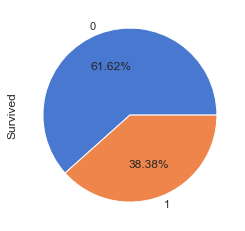

In [6]:
# 绘制存活的比例：
train_data['Survived'].value_counts().plot.pie(autopct = '%1.2f%%')
# 总体存活率38.38%

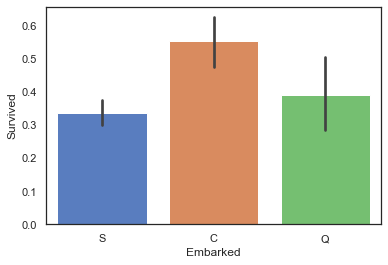

In [7]:
# 单特征值对存活率影响分析
#  Embarked对Survived的影响
sns.barplot(data=train_data,x='Embarked',y='Survived')

In [8]:
# Cherbourg,该港口登录游客存活率最高
#计算不同类型embarked的乘客，其生存率为多少
print('Embarked为"S"的乘客，其生存率为%.2f'%full['Survived'][full['Embarked']=='S'].value_counts(normalize=True)[1])
print('Embarked为"C"的乘客，其生存率为%.2f'%full['Survived'][full['Embarked']=='C'].value_counts(normalize=True)[1])
print('Embarked为"Q"的乘客，其生存率为%.2f'%full['Survived'][full['Embarked']=='Q'].value_counts(normalize=True)[1])

Embarked为"S"的乘客，其生存率为0.34
Embarked为"C"的乘客，其生存率为0.55
Embarked为"Q"的乘客，其生存率为0.39


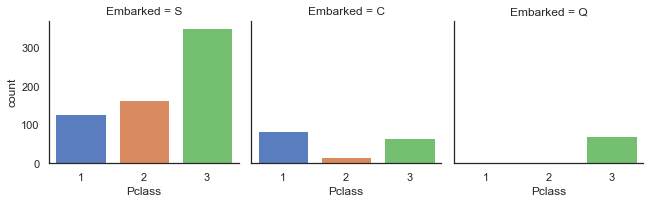

In [9]:
# 法国登船乘客存活率较高，进一步分析法国等船乘客特征，如船舱等级、性别、年龄
sns.factorplot('Pclass',col='Embarked',data=train_data,kind='count',size=3)
# 观察三组图像，法国港口头等舱比例较高，可能是引起存活率高的原因，其他因素分布区别不是很明显

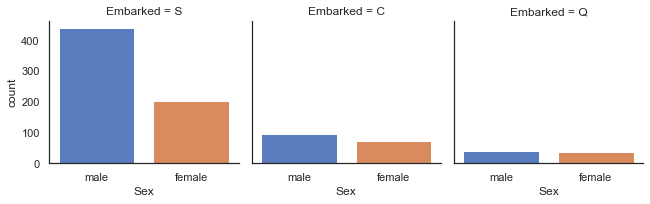

In [10]:
sns.factorplot('Sex',col='Embarked',data=train_data,kind='count',size=3)

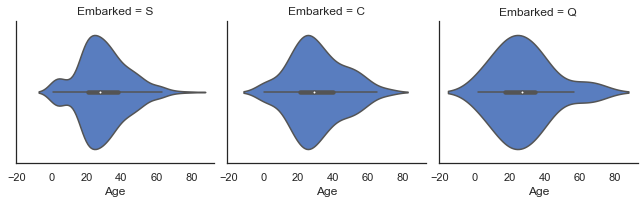

In [11]:
sns.factorplot('Age',col='Embarked',data=train_data,kind='violin',size=3)

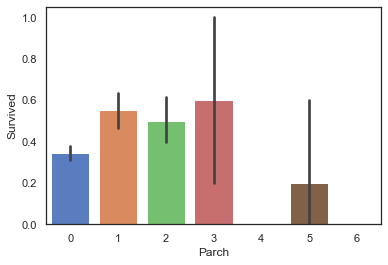

In [12]:
# Parch与Survived：当乘客同行的父母及子女数量适中时，生存率较高
sns.barplot(data=train_data,x='Parch',y='Survived')

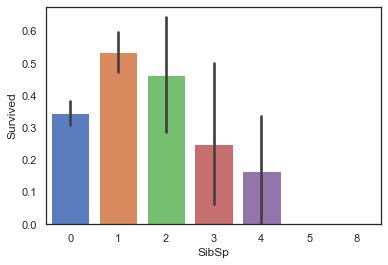

In [13]:
# SibSp与Survived：当乘客同行的同辈数量适中时生存率较高
sns.barplot(data=train_data,x='SibSp',y='Survived')

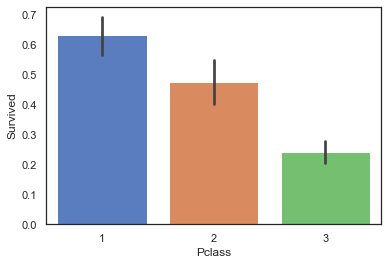

In [14]:
# Pclass与Survived：乘客客舱等级越高，生存率越高,且规律明确，重点指标
sns.barplot(data=train_data,x='Pclass',y='Survived')

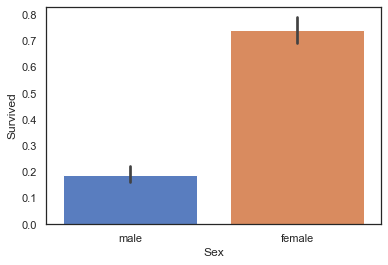

In [15]:
# Sex与Survived：女性的生存率远高于男性
sns.barplot(data=train_data,x='Sex',y='Survived')

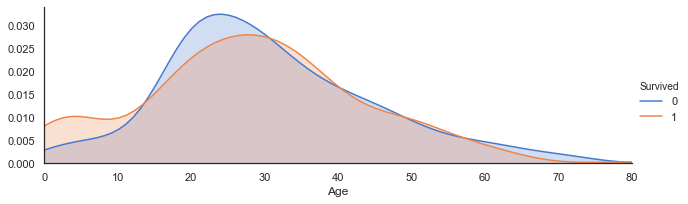

In [16]:
# Age与Survived：当乘客年龄段在0-10岁期间时生存率会较高,存活概率大于死亡概率

#创建坐标轴
ageFacet=sns.FacetGrid(train_data,hue='Survived',aspect=3)
#作图，选择图形类型
ageFacet.map(sns.kdeplot,'Age',shade=True)
#其他信息：坐标轴范围、标签等
ageFacet.set(xlim=(0,train_data['Age'].max()))
ageFacet.add_legend()

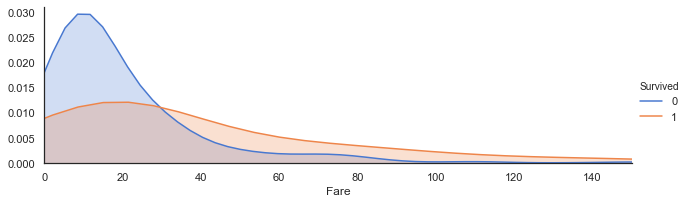

In [17]:
# Fare与Survived：当票价低于18左右时乘客生存率较低，票价越高生存率一般越高
#创建坐标轴
ageFacet=sns.FacetGrid(train_data,hue='Survived',aspect=3)
ageFacet.map(sns.kdeplot,'Fare',shade=True)
ageFacet.set(xlim=(0,150))
ageFacet.add_legend()

In [18]:
# 数据清洗
#对Cabin缺失值进行处理，利用U（Unknown）填充缺失值
full['Cabin']=full['Cabin'].fillna('U')

In [19]:
#对Embarked缺失值进行处理，查看缺失值情况
full[full['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [20]:
# 对Embarked采用众数填充
full['Embarked']=full['Embarked'].fillna(full['Embarked'].mode()[0])

In [21]:
#查看缺失数据情况，该乘客乘坐3等舱，登船港口为S，舱位未知
full[full['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,U,S


In [22]:
# 对Fare缺失值采用3等舱，S登船乘客平均票价填充
full['Fare']=full['Fare'].fillna(full[(full['Pclass']==3)&(full['Embarked']=='S')&(full['Cabin']=='U')]['Fare'].mean())

In [23]:
# 构造新特征Title
full['Title']=full['Name'].map(lambda x:x.split(',')[1].split('.')[0].strip())
title_Dict = {}
title_Dict.update(dict.fromkeys(["Capt", "Col", "Major", "Dr", "Rev"], "Officer"))
title_Dict.update(
    dict.fromkeys(["Don", "Sir", "the Countess", "Dona", "Lady"], "Royalty")
)
title_Dict.update(dict.fromkeys(["Mme", "Ms", "Mrs"], "Mrs"))
title_Dict.update(dict.fromkeys(["Mlle", "Miss"], "Miss"))
title_Dict.update(dict.fromkeys(["Mr"], "Mr"))
title_Dict.update(dict.fromkeys(["Master", "Jonkheer"], "Master"))
full["Title"] = full["Title"].map(title_Dict)    

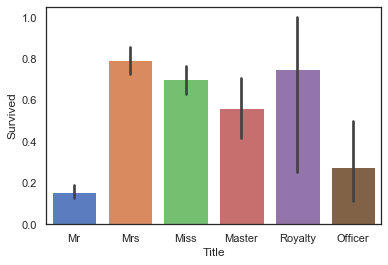

In [24]:
#可视化分析Title与Survived之间关系
sns.barplot(data=full,x='Title',y='Survived')

In [25]:
full["Title"].value_counts()

Mr         757
Miss       262
Mrs        200
Master      62
Officer     23
Royalty      5
Name: Title, dtype: int64

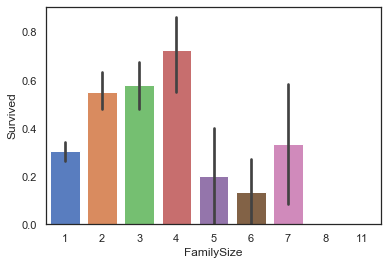

In [26]:
# 统计家庭成员数量，分析对存活概率的影响
full['FamilySize'] = full['SibSp'] + full['Parch'] + 1
sns.barplot(data=full,x='FamilySize',y='Survived')
# 单身或者家庭成员过多，都会导致存活率降低

In [27]:
#我们按照家庭成员人数多少，将家庭规模分为“小、中、大”三类：
def familysize(familyNum):
    if (familyNum==1)|(familyNum>=4)&(familyNum<=7):
        return 0
    elif (familyNum>=2)&(familyNum<=4):
        return 1
    else:
        return 2

full['FamilySize']=full['FamilySize'].map(familysize)

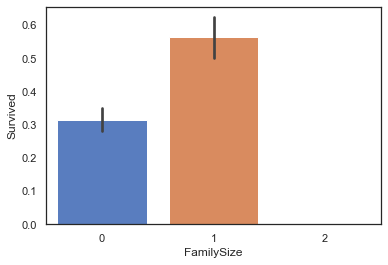

In [28]:
#查看familySize与Survived
sns.barplot(data=full,x='FamilySize',y='Survived')

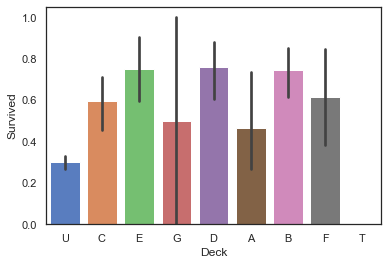

In [29]:
#提取Cabin字段首字母
full['Deck']=full['Cabin'].map(lambda x:x[0])
#查看不同Deck类型乘客的生存率
sns.barplot(data=full,x='Deck',y='Survived')

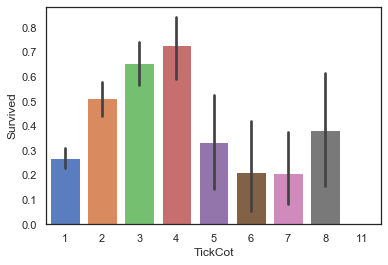

In [30]:
#提取各票号的乘客数量
TickCountDict={}
TickCountDict=full['Ticket'].value_counts()
#将同票号乘客数量数据并入数据集中
full['TickCot']=full['Ticket'].map(TickCountDict)
#查看TickCot与Survived之间关系
sns.barplot(data=full,x='TickCot',y='Survived')

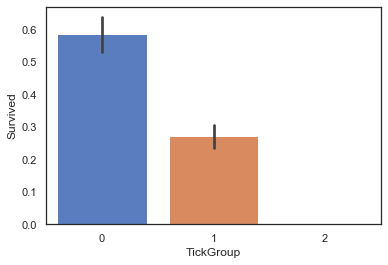

In [31]:
#按照TickCot大小，将TickGroup分为三类。
def TickCountGroup(num):
    if (num>=2)&(num<=4):
        return 0
    elif (num==1)|((num>=5)&(num<=8)):
        return 1
    else :
        return 2
#得到各位乘客TickGroup的类别
full['TickGroup']=full['TickCot'].map(TickCountGroup)
#查看TickGroup与Survived之间关系
sns.barplot(data=full,x='TickGroup',y='Survived')

In [32]:
# Age缺失信息补充
#筛选数据集
AgePre=full[['Age','Parch','Pclass','SibSp','Title','FamilySize','TickCot']]
#进行one-hot编码
AgePre=pd.get_dummies(AgePre)
ParAge=pd.get_dummies(AgePre['Parch'],prefix='Parch')
SibAge=pd.get_dummies(AgePre['SibSp'],prefix='SibSp')
PclAge=pd.get_dummies(AgePre['Pclass'],prefix='Pclass')
#查看变量间相关性
AgeCorrDf=pd.DataFrame()
AgeCorrDf=AgePre.corr()
AgeCorrDf['Age'].sort_values()

Pclass          -0.408106
Title_Master    -0.385380
Title_Miss      -0.282977
SibSp           -0.243699
TickCot         -0.185284
Parch           -0.150917
FamilySize      -0.015624
Title_Royalty    0.057337
Title_Officer    0.166771
Title_Mr         0.183965
Title_Mrs        0.215091
Age              1.000000
Name: Age, dtype: float64

In [33]:
#拼接数据
AgePre=pd.concat([AgePre,ParAge,SibAge,PclAge],axis=1)

In [34]:
#拆分实验集和预测集
AgeKnown=AgePre[AgePre['Age'].notnull()]
AgeUnKnown=AgePre[AgePre['Age'].isnull()]

#生成实验数据的特征和标签
AgeKnown_X=AgeKnown.drop(['Age'],axis=1)
AgeKnown_y=AgeKnown['Age']
#生成预测数据的特征
AgeUnKnown_X=AgeUnKnown.drop(['Age'],axis=1)

#利用随机森林构建模型
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(random_state=None,n_estimators=500,n_jobs=-1)
rfr.fit(AgeKnown_X,AgeKnown_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [35]:
#预测年龄
AgeUnKnown_y=rfr.predict(AgeUnKnown_X)
#填充预测数据
full.loc[full['Age'].isnull(),['Age']]=AgeUnKnown_y

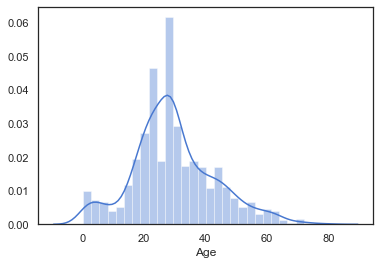

In [36]:
# 可视化年龄分布
sns.distplot(full['Age'])

In [37]:
# #提取乘客的姓氏及相应的乘客数
# full['Surname']=full['Name'].map(lambda x:x.split(',')[0].strip())
# SurNameDict={}
# SurNameDict=full['Surname'].value_counts()
# full['SurnameNum']=full['Surname'].map(SurNameDict)

# #将数据分为两组
# MaleDf=full[(full['Sex']=='male')&(full['Age']>12)&(full['FamilySize']>=2)]
# FemChildDf=full[((full['Sex']=='female')|(full['Age']<=12))&(full['FamilySize']>=2)]

# #分析男性同组效应
# MSurNamDf=MaleDf['Survived'].groupby(MaleDf['Surname']).mean()

# #获得生存率为1的姓氏
# MSurNamDict={}
# MSurNamDict=MSurNamDf[MSurNamDf.values==1].index

# #分析女性及儿童同组效应
# FCSurNamDf=FemChildDf['Survived'].groupby(FemChildDf['Surname']).mean()

# #获得生存率为0的姓氏
# FCSurNamDict={}
# FCSurNamDict=FCSurNamDf[FCSurNamDf.values==0].index

# #对数据集中这些姓氏的男性数据进行修正：1、性别改为女；2、年龄改为5。
# full.loc[(full['Survived'].isnull())&(full['Surname'].isin(MSurNamDict))&(full['Sex']=='male'),'Age']=5
# full.loc[(full['Survived'].isnull())&(full['Surname'].isin(MSurNamDict))&(full['Sex']=='male'),'Sex']='female'

# #对数据集中这些姓氏的女性及儿童的数据进行修正：1、性别改为男；2、年龄改为60。
# full.loc[(full['Survived'].isnull())&(full['Surname'].isin(FCSurNamDict))&((full['Sex']=='female')|(full['Age']<=12)),'Age']=60
# full.loc[(full['Survived'].isnull())&(full['Surname'].isin(FCSurNamDict))&((full['Sex']=='female')|(full['Age']<=12)),'Sex']='male'
# fullSel=full.drop(['Cabin','Name','Ticket','PassengerId','Surname','SurnameNum'],axis=1)

In [38]:
# 对年龄进行分段处理
full['AgeBin'] = pd.factorize(pd.cut(full['Age'], 5))[0]

In [39]:
full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Deck,TickCot,TickGroup,AgeBin
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,Mr,1,U,1,1,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1,C,2,0,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,Miss,0,U,1,1,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1,C,2,0,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,Mr,0,U,1,1,1


In [40]:
#人工筛选
fullSel=full.drop(['Cabin','Name','Ticket','PassengerId'],axis=1)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text xticklabel objects>)

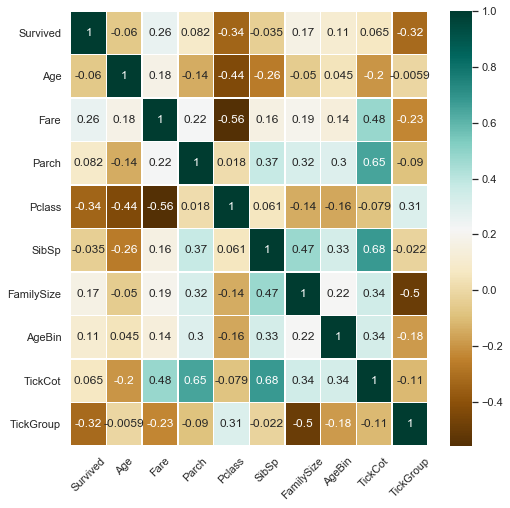

In [41]:
#热力图，查看Survived与其他特征间相关性大小
plt.figure(figsize=(8,8))
sns.heatmap(fullSel[['Survived','Age','Embarked','Fare','Parch','Pclass',
                    'Sex','SibSp','Title','FamilySize','Deck','AgeBin',
                     'TickCot','TickGroup']].corr(),cmap='BrBG',annot=True,
           linewidths=.5)
plt.xticks(rotation=45)

In [42]:
fullSel.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,Deck,TickCot,TickGroup,AgeBin
0,0.0,3,male,22.0,1,0,7.2500,S,Mr,1,U,1,1,0
1,1.0,1,female,38.0,1,0,71.2833,C,Mrs,1,C,2,0,1
2,1.0,3,female,26.0,0,0,7.9250,S,Miss,0,U,1,1,0
3,1.0,1,female,35.0,1,0,53.1000,S,Mrs,1,C,2,0,1
4,0.0,3,male,35.0,0,0,8.0500,S,Mr,0,U,1,1,1


In [43]:
fullSel=fullSel.drop(['SibSp','TickCot','Parch'],axis=1)
# fullSel.drop(['AgeBin'],axis=1)

In [44]:
#one-hot编码
fullSel=pd.get_dummies(fullSel)
PclassDf=pd.get_dummies(full['Pclass'],prefix='Pclass')
TickGroupDf=pd.get_dummies(full['TickGroup'],prefix='TickGroup')
FamilySizeDf=pd.get_dummies(full['FamilySize'],prefix='FamilySize')
AgeBinDf=pd.get_dummies(full['AgeBin'],prefix='AgeBin')

fullSel=pd.concat([fullSel,PclassDf,TickGroupDf,FamilySizeDf, AgeBinDf],axis=1)

In [45]:
# 输入数据标准化处理
fullSel['Age'] = preprocessing.StandardScaler().fit_transform(fullSel['Age'].values.reshape(-1, 1))
fullSel['Fare'] = preprocessing.StandardScaler().fit_transform(fullSel['Fare'].values.reshape(-1, 1))

In [46]:
fullSel.head()

,Survived,Pclass,Age,Fare,FamilySize,TickGroup,AgeBin,Sex_female,Sex_male,Embarked_C,...,TickGroup_1,TickGroup_2,FamilySize_0,FamilySize_1,FamilySize_2,AgeBin_0,AgeBin_1,AgeBin_2,AgeBin_3,AgeBin_4
0,0.0,3,-0.560991,-0.503292,1,1,0,0,1,0,...,1,0,0,1,0,1,0,0,0,0
1,1.0,1,0.625824,0.734743,1,0,1,1,0,1,...,0,0,0,1,0,0,1,0,0,0
2,1.0,3,-0.264287,-0.490242,0,1,0,1,0,0,...,1,0,1,0,0,1,0,0,0,0
3,1.0,1,0.403296,0.383183,1,0,1,1,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0.0,3,0.403296,-0.487825,0,1,1,0,1,0,...,1,0,1,0,0,0,1,0,0,0


In [47]:
#拆分实验数据与预测数据
experData=fullSel[fullSel['Survived'].notnull()]
preData=fullSel[fullSel['Survived'].isnull()]

experData_X=experData.drop('Survived',axis=1)
experData_y=experData['Survived']
preData_X=preData.drop('Survived',axis=1)

#导入机器学习算法库
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold

#设置kfold，交叉采样法拆分数据集
kfold=StratifiedKFold(n_splits=10)

#汇总不同模型算法
classifiers=[]
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(ExtraTreesClassifier())
classifiers.append(GradientBoostingClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression())
classifiers.append(LinearDiscriminantAnalysis())

In [48]:
#不同机器学习交叉验证结果汇总
cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,experData_X,experData_y,
                                      scoring='accuracy',cv=kfold,n_jobs=-1))

In [49]:
#求出模型得分的均值和标准差
cv_means=[]
cv_std=[]
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
#汇总数据
cvResDf=pd.DataFrame({'cv_mean':cv_means,
                     'cv_std':cv_std,
                     'algorithm':['SVC','DecisionTreeCla','RandomForestCla','ExtraTreesCla',
                                  'GradientBoostingCla','KNN','LR','LinearDiscrimiAna']})

cvResDf

,cv_mean,cv_std,algorithm
0,0.823770,0.037036,SVC
1,0.780037,0.054096,DecisionTreeCla
2,0.805893,0.047651,RandomForestCla
3,0.796904,0.042496,ExtraTreesCla
4,0.830549,0.046356,GradientBoostingCla
5,0.809226,0.024921,KNN
6,0.817091,0.032370,LR
7,0.800262,0.035912,LinearDiscrimiAna


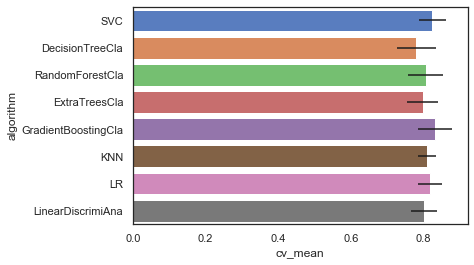

In [50]:
# 算法表现
sns.barplot(data=cvResDf,x='cv_mean',y='algorithm',**{'xerr':cv_std})

In [51]:
#GradientBoostingClassifier模型
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }
modelgsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, 
                                     scoring="accuracy", n_jobs= -1, verbose = 1)
modelgsGBC.fit(experData_X,experData_y)

#LogisticRegression模型
modelLR=LogisticRegression()
LR_param_grid = {'C' : [1,2,3],
                'penalty':['l1','l2']}
modelgsLR = GridSearchCV(modelLR,param_grid = LR_param_grid, cv=kfold, 
                                     scoring="accuracy", n_jobs= -1, verbose = 1)
modelgsLR.fit(experData_X,experData_y)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   23.7s finished
Fitting 10 folds for each of 6 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 2, 3], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [52]:
#modelgsGBC模型
print('modelgsGBC模型得分为：%.3f'%modelgsGBC.best_score_)
#modelgsLR模型
print('modelgsLR模型得分为：%.3f'%modelgsLR.best_score_)

modelgsGBC模型得分为：0.838
modelgsLR模型得分为：0.817


<Figure size 432x288 with 0 Axes>

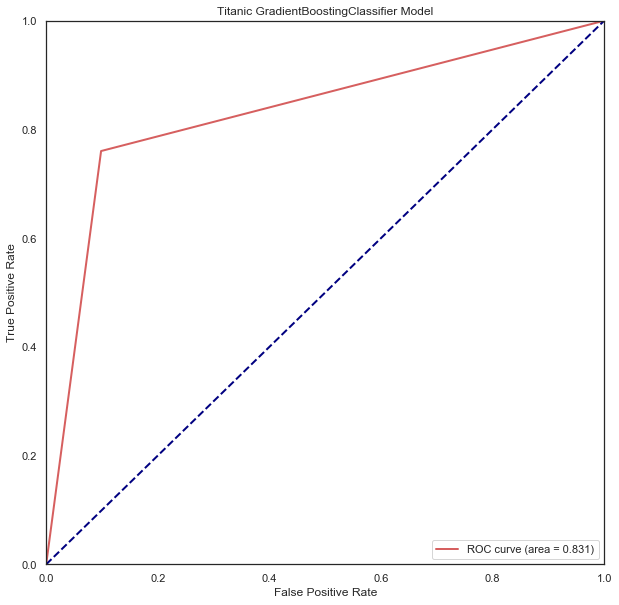

In [53]:
#查看模型ROC曲线
#求出测试数据模型的预测值
modelgsGBCtestpre_y=modelgsGBC.predict(experData_X).astype(int)
#画图
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(experData_y, modelgsGBCtestpre_y) ###计算真正率和假正率
roc_auc = auc(fpr,tpr) ###计算auc的值

plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='r',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Titanic GradientBoostingClassifier Model')
plt.legend(loc="lower right")
plt.show()

In [54]:
#混淆矩阵
from sklearn.metrics import confusion_matrix
print('GradientBoostingClassifier模型混淆矩阵为\n',confusion_matrix(experData_y.astype(int).astype(str),modelgsGBCtestpre_y.astype(str)))

GradientBoostingClassifier模型混淆矩阵为
 [[495  54]
 [ 82 260]]


In [55]:
#TitanicGBSmodle
GBCpreData_y=modelgsGBC.predict(preData_X)
GBCpreData_y=GBCpreData_y.astype(int)
#导出预测结果
GBCpreResultDf=pd.DataFrame()
GBCpreResultDf['PassengerId']=full['PassengerId'][full['Survived'].isnull()]
GBCpreResultDf['Survived']=GBCpreData_y
GBCpreResultDf
#将预测结果导出为csv文件
GBCpreResultDf.to_csv(r'./Data/TitanicGBSmodle.csv',index=False)

In [ ]:
# 模型融合